In [17]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environnement Cart Pole

On travaille dans un premier temps avec l'environnement Cart Pole dont pourra consulter la documentation : https://gymnasium.farama.org/environments/classic_control/cart_pole/. Dans la pratique, on considère ce problème *résolu* lorsqu'on obtient une politique qui fait systématiquement durer les épisodes pendant 500 étapes. On souhaite le résoudre à l'aide de méthodes de gradient de politique et des réseaux de neurones.

In [18]:
env = gym.make("CartPole-v1")

La fonction suivante permet de visualiser le résultat d'une politique sur un épisode. La politique est donnée sous la forme d'une fonction prenant en argument un état et renvoyant une action (éventuellement tirée selon une distribuiton de probabilité).

In [19]:
def render_policy(pi):
    local_env = gym.make("CartPole-v1", render_mode='rgb_array')
    s = local_env.reset()[0]
    terminated = False
    truncated = False
    while not (terminated or truncated):
        a = pi(s)
        s, r, terminated, truncated , _ = local_env.step(a)
        clear_output(wait=True)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(local_env.render())
        plt.show()
    plt.close()

**Question 1**: Implémenter et observer la politique qui pousse toujours vers la gauche.

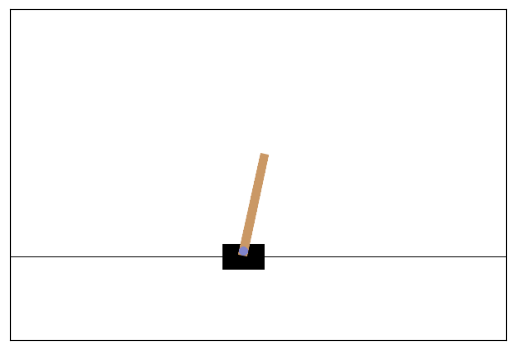

In [20]:
def pi_(s):
    return 0

render_policy(pi_)

Voici un exemple de réseau de neurones dont l'entrée est de dimension 64, la sortie de dimension 8, avec deux couches cachées de tailles 32 et 16, où les fonctions d'activation sont ReLU, sauf la dernière qui est la fonction softmax.

In [21]:
net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, env.action_space.n),
    nn.Softmax(dim=-1))

**Question 2**: Définir une famille paramétrique de politiques, de type softmax, sous la forme d'un (petit) réseau de neurones. De quelles dimensions doivent être l'entrée et la sortie d'un tel réseau ?

In [22]:
pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, env.action_space.n),
    nn.Softmax(dim=-1))

La fonction suivante prend en argument une politique (sous la forme d'un réseau de neurones) et un état, et qui renvoie une action tirée selon la distribution spécifiée par la politique dans cet été

In [23]:
def draw_action(pi, s):
    probs = pi(torch.tensor(s))
    dist = torch.distributions.Categorical(probs)
    a = dist.sample().item()
    return a

Les algorithmes d'apprentissage par renforcement faisant intervenir des familles paramétriques sont initialement définies à l'aide d'itérations de type SGD pour mettre à jour les paramètres. On peut les adapter avec des variantes/sophistications de SGD réputées pour leur efficacité pratique, e.g. RMSprop ou Adam.

In [24]:
learning_rate = 3e-3 # à ajuster
optimizer = optim.Adam(pi.parameters(), lr=learning_rate)

## REINFORCE (sans baseline)

Dans sa version la plus simple, l'algorithme REFINFORCE (sans baseline) met à jour les paramètres après chaque épisode comme suit (en reprenant les notations du polycopié):
$$\theta_{k+1}=\theta_k+\alpha\sum_{t=0}^{+\infty}\gamma^t\left( \sum_{t'=1}^{+\infty}\gamma^{t'-1}R_{t+t',k} \right) \nabla_{\theta}\log \pi_{\theta_k}(A_{t,k}|S_{t,k}),\qquad k\geqslant 0.$$

On note que la quantité (qu'on peut appeler *perte*) $\sum_{t=0}^{+\infty}\gamma^t\left( \sum_{t'=1}^{+\infty}\gamma^{t'-1}R_{t+t',k} \right) \nabla_{\theta}\log \pi_{\theta_k}(A_{t,k}|S_{t,k})$ est l'opposé du gradient (par rapport à theta) de la quantité suivante $-\sum_{t=0}^{+\infty}\gamma^t\left( \sum_{t'=1}^{+\infty}\gamma^{t'-1}R_{t+t',k} \right)\log \pi_{\theta_k}(A_{t,k}|S_{t,k})$.

**Question 3**: Implémenter l'algorithe REINFORCE (sans baseline) et le faire tourner pendant 1000 épisodes. On utilisera la fonctionnalité de différentiation automatique de PyTorch. Tracer l'évolution du paiement cumulé de chaque épisode. Visualiser la politique obtenue. *Jouer sur le `learning_rate` et la structure du réseau de neurones pour obtenir un meilleur apprentissage (commencer par de très petits réseaux). Ne pas oublier de redéfinir le réseau de neurones à chaque nouvelle utilisation de l'algorithme, afin de ne pas garder les paramètres précédemment obtenus.*

Episode 1000/1000, Paiement cumulé: 500.0

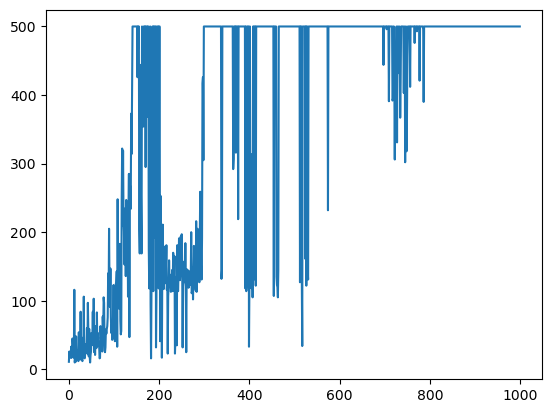

In [25]:
pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, env.action_space.n),
    nn.Softmax(dim=-1))

learning_rate = 1e-2
optimizer = optim.Adam(pi.parameters(), lr=learning_rate)

n_episodes = 1000
gamma = 1
episode_rewards = []

for episode in range(n_episodes):
    s = env.reset()[0] # démarre un nouvel épisode
    
    # Listes pour stocker les états, actions et paiements de cet épisode
    ss, aa, rr = [], [], []
    
    terminated = False
    truncated =  False
    while not (terminated or truncated):
        a = draw_action(pi, s)
        s_, r, terminated, truncated, _ = env.step(a)
        
        ss.append(s)
        aa.append(a)
        rr.append(r)
        
        s = s_
    
    G = 0
    loss = torch.tensor(0)
    # Calculer dans 'loss' la valeur de la fonction de perte évoquée dans la question précédente
    for s,a,r in zip(reversed(ss), reversed(aa), reversed(rr)):
        G = r + gamma * G
        loss = gamma * loss - G*torch.log(pi(torch.tensor(s))[a])

    # Le code suivant calcule le gradient de la fonction de perte (par différentiation automatique), puis utilise ce dernier pour mettre à jour les paramètres du réseau de neurones.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculer la somme des paiements de l'épisode
    episode_reward = sum(rr)
    print("\rEpisode {}/{}, Paiement cumulé: {}".format(episode + 1, n_episodes, episode_reward), end="")
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)
plt.show()

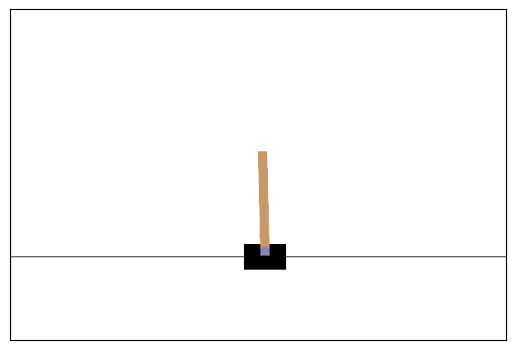

In [26]:
render_policy(lambda s:draw_action(pi,s))

## REINFORCE (avec baseline)

**Question 4**: Implémenter REFINFORCE (avec baseline). Comparer empiriquement les deux algorithmes.

Episode 1000/1000, Paiement cumulé: 500.0

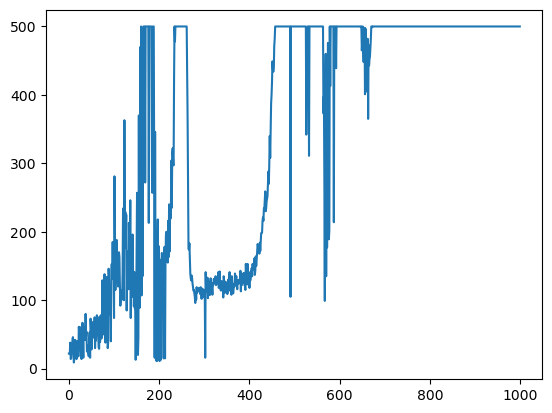

In [27]:
pi_lr = 1e-2
v_lr = 1e-2
gamma = 1
n_episodes = 1000

pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, env.action_space.n),
    nn.Softmax(dim=-1))

v = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 8),
    nn.ReLU(),
    nn.Linear(8, 1))

episode_rewards = []
pi_optimizer = optim.Adam(pi.parameters(), lr=pi_lr)
v_optimizer = optim.Adam(v.parameters(), lr=v_lr)

for episode in range(n_episodes):
    s = env.reset()[0] 
    
    ss, aa, rr = [], [], []
    
    terminated = False
    truncated =  False
    while not (terminated or truncated):
        a = draw_action(pi, s)
        s_, r, terminated, truncated, _ = env.step(a)
        
        ss.append(s)
        aa.append(a)
        rr.append(r)
        
        s = s_
    
    G = 0
    pi_loss = torch.tensor(0)
    v_loss = torch.tensor(0)
    for s,a,r in zip(reversed(ss), reversed(aa), reversed(rr)):
        G = r + gamma * G
        delta = G-v(torch.tensor(s))
        v_loss = v_loss - delta* v(torch.tensor(s))
        pi_loss = gamma * pi_loss - delta*torch.log(pi(torch.tensor(s))[a])

    v_optimizer.zero_grad()
    pi_optimizer.zero_grad()

    pi_loss.backward(retain_graph=True)
    v_loss.backward()

    v_optimizer.step()
    pi_optimizer.step()

    episode_reward = sum(rr)
    print("\rEpisode {}/{}, Paiement cumulé: {}".format(episode + 1, n_episodes, episode_reward), end="")
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)
plt.show()

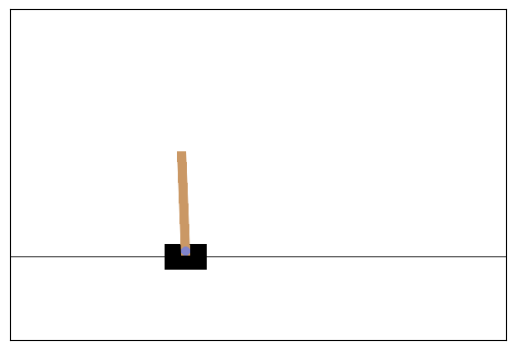

In [28]:
render_policy(lambda s:draw_action(pi,s))

## A2C

On considère une variante de l'algorithme acteur-critique vu en cours, où la mise à jour des paramètres s'écrit (dans sa version la plus simple, c'est-à-dire avec des itérations de type SGD) :
$$\Delta_{t,k}=R_{t+1,k}+\gamma v_{w_{t,k}}(S_{t+1,k})-v_{w_{t,k}}(S_{t,k})$$
$$\theta_{t+1,k}=\theta_{t,k}+\alpha\Delta_{t,k}\nabla_{\theta}\log \pi_{\theta_{t,k}}(A_{t,k}|S_{t,k})$$
$$w_{t+1,k}=w_{t,k}+\beta \Delta_{t,k}(\gamma \nabla_{w} v_{w_{t,k}}(S_{t+1,k})- \nabla_{w} v_{w_{t,k}}(S_{t,k})),$$
où on a repris les notations du polycopié.

**Question 5**: Réécrire la mise à jour du paramètre $w$ à l'aide du gradient d'une certaine quantité.

**Question 6**: Implémenter l'algorithme et observer les résultats.

Episode 1000/1000, Paiement cumulé: 382.0

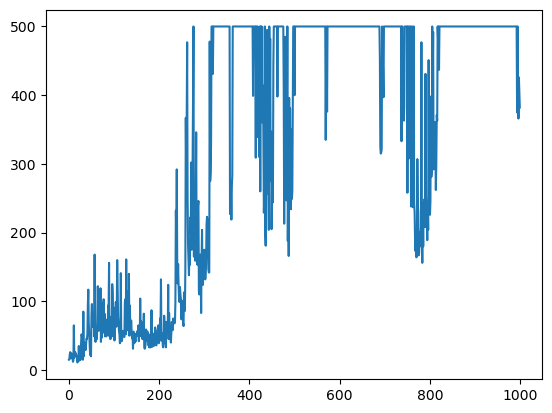

In [33]:
pi_lr = 3e-3
v_lr = 3e-3
gamma = 1
n_episodes = 1000

pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, env.action_space.n),
    nn.Softmax(dim=-1))

v = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 8),
    nn.ReLU(),
    nn.Linear(8, 1))

pi_optimizer = optim.Adam(pi.parameters(), lr=pi_lr)
v_optimizer = optim.Adam(v.parameters(), lr=v_lr)

episode_rewards = []

for episode in range(n_episodes):
    s = env.reset()[0]
    
    terminated = False
    truncated =  False

    t = 0
    episode_reward = 0
    while not (terminated or truncated):
        a = draw_action(pi, s)
        s_, r, terminated, truncated, _ = env.step(a)
        episode_reward += r

        delta = torch.tensor(r)+gamma*v(torch.tensor(s_))-v(torch.tensor(s))
        v_loss = delta**2
        pi_loss = - delta * torch.log(pi(torch.tensor(s))[a])

        v_optimizer.zero_grad()
        pi_optimizer.zero_grad()

        pi_loss.backward(retain_graph=True)
        v_loss.backward()

        v_optimizer.step()
        pi_optimizer.step()

        s = s_
        t+= 1
    
    # Print some info
    print("\rEpisode {}/{}, Paiement cumulé: {}".format(episode + 1, n_episodes, episode_reward), end="")
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)
plt.show()

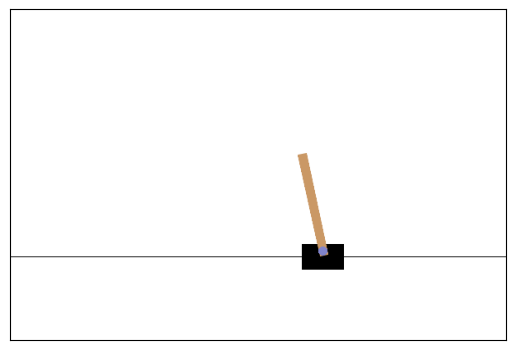

In [35]:
render_policy(lambda s:draw_action(pi,s))

# Environnement Acrobot

Cet environnement est légèrement plus difficile à résoudre que le précédent. On pourra consulter la documentation ici : https://gymnasium.farama.org/environments/classic_control/acrobot/.
Dans la pratique, on considère que ce problème est résolu lorsqu'on obtient une politique qui arrive presque toujours à terminer les épidodes en moins de 100 étapes.

In [36]:
env = gym.make("Acrobot-v1")

def render_policy(pi):
    local_env = gym.make("Acrobot-v1", render_mode='rgb_array')
    s = local_env.reset()[0]
    terminated = False
    truncated = False
    while not (terminated or truncated):
        a = pi(s)
        s, r, terminated, truncated , _ = local_env.step(a)
        clear_output(wait=True)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(local_env.render())
        plt.show()
    plt.close()

**Question 7**: Résoudre ce problème à l'aide des algorithmes vus précédemment.

Episode 1000/1000, Cumul reward: -104.0

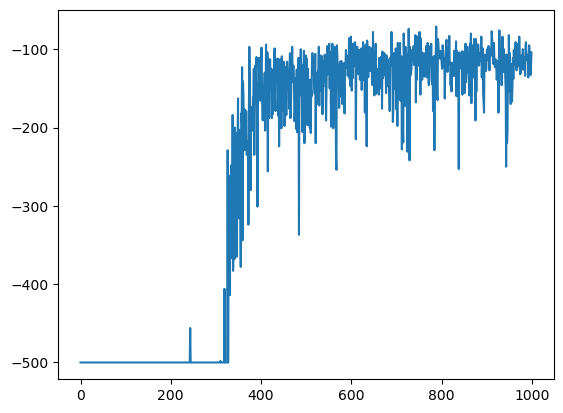

In [37]:
gamma = 1
learning_rate = 1e-3
n_episodes = 1000
pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, env.action_space.n),
    nn.Softmax(dim=-1))
optimizer = optim.Adam(pi.parameters(), lr=learning_rate)

episode_rewards = []

for episode in range(n_episodes):
    s = env.reset()[0]  
    ss, aa, rr = [], [], []
    
    terminated = False
    truncated =  False
    while not (terminated or truncated):
        a = draw_action(pi, s)
        s_, r, terminated, truncated, _ = env.step(a)

        ss.append(s)
        aa.append(a)
        rr.append(r)
        
        s = s_
    
    G = 0
    loss = torch.tensor(0)
    for s,a,r in zip(reversed(ss), reversed(aa), reversed(rr)):
        G = r + gamma * G
        loss = gamma * loss - G*torch.log(pi(torch.tensor(s))[a])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    episode_reward = sum(rr)
    print("\rEpisode {}/{}, Cumul reward: {}".format(episode + 1, n_episodes, episode_reward), end="")
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)
plt.show()

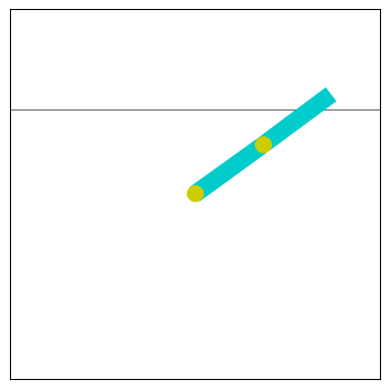

In [40]:
render_policy(lambda s:draw_action(pi,s))

Episode 1000/1000, Cumul reward: -88.0

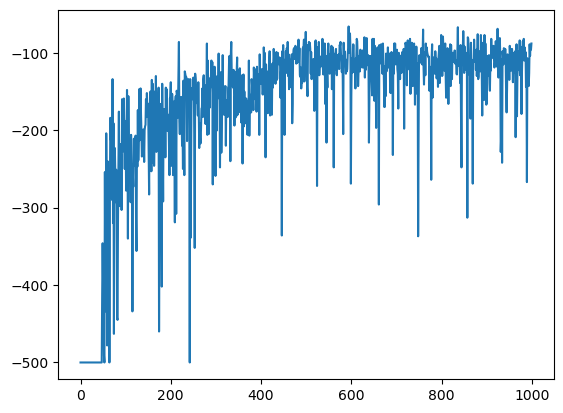

In [41]:
pi_lr = 1e-3
v_lr = 1e-3
gamma = 1
n_episodes = 1000

pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, env.action_space.n),
    nn.Softmax(dim=-1))

v = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, 1))

pi_optimizer = optim.Adam(pi.parameters(), lr=pi_lr)
v_optimizer = optim.Adam(v.parameters(), lr=v_lr)

episode_rewards = []

for episode in range(n_episodes):
    s = env.reset()[0]
    
    ss, aa, rr = [], [], []
    
    terminated = False
    truncated =  False

    while not (terminated or truncated):
        a = draw_action(pi, s)

        s_, r, terminated, truncated, _ = env.step(a)
        
        ss.append(s)
        aa.append(a)
        rr.append(r)
        
        s = s_
    
    G = 0

    pi_loss = torch.tensor(0)
    v_loss = torch.tensor(0)
    for s,a,r in zip(reversed(ss), reversed(aa), reversed(rr)):
        G = r + gamma * G
        delta = G-v(torch.tensor(s))
        v_loss = v_loss - delta* v(torch.tensor(s))
        pi_loss = gamma * pi_loss - delta*torch.log(pi(torch.tensor(s))[a])

    v_optimizer.zero_grad()
    pi_optimizer.zero_grad()

    pi_loss.backward(retain_graph=True)
    v_loss.backward()

    v_optimizer.step()
    pi_optimizer.step()

    episode_reward = sum(rr)
    print("\rEpisode {}/{}, Cumul reward: {}".format(episode + 1, n_episodes, episode_reward), end="")
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards)
plt.show()

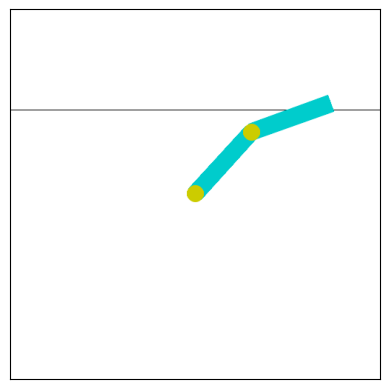

In [44]:
render_policy(lambda s:draw_action(pi,s))

Episode 1000/1000, Cumul reward: -83.0

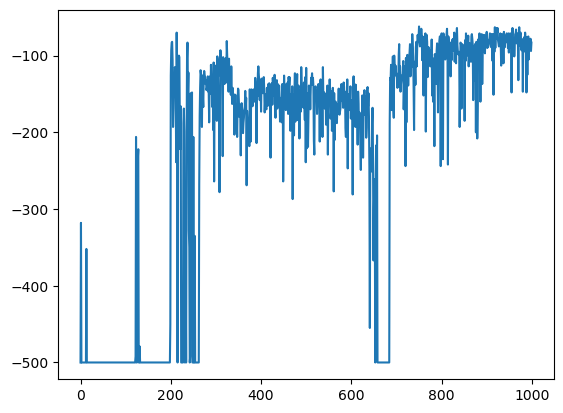

In [48]:
pi_lr = 3e-4
v_lr = 3e-4
gamma = 1
n_episodes = 1000

pi = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, env.action_space.n),
    nn.Softmax(dim=-1))

v = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, 1))

pi_optimizer = optim.Adam(pi.parameters(), lr=pi_lr)
v_optimizer = optim.Adam(v.parameters(), lr=v_lr)

episode_rewards = []

for episode in range(n_episodes):
    s = env.reset()[0]
    
    terminated = False
    truncated =  False

    cumul_r = 0
    while not (terminated or truncated):
        a = draw_action(pi, s)

        s_, r, terminated, truncated, _ = env.step(a)
        cumul_r += r

        delta = torch.tensor(r)+gamma*v(torch.tensor(s_))-v(torch.tensor(s))
        v_loss = delta**2
        pi_loss = - delta * torch.log(pi(torch.tensor(s))[a])

        v_optimizer.zero_grad()
        pi_optimizer.zero_grad()

        pi_loss.backward(retain_graph=True)
        v_loss.backward()

        v_optimizer.step()
        pi_optimizer.step()

        s = s_
        
    print("\rEpisode {}/{}, Cumul reward: {}".format(episode + 1, n_episodes, cumul_r), end="")
    episode_rewards.append(cumul_r)
    
plt.plot(episode_rewards)
plt.show()

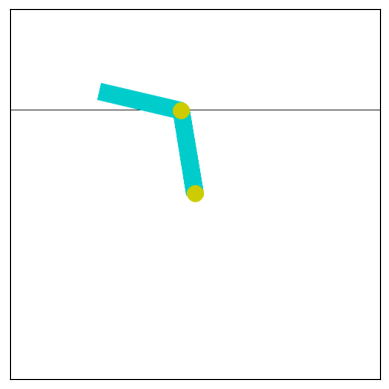

In [56]:
render_policy(lambda s:draw_action(pi,s))